# Import libraries

In [1]:
import PIL
import os
from PIL import Image
from numpy import asarray
import numpy as np
import tensorflow as tf
import keras_spiking
import matplotlib.pyplot as plt
import util
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import pandas as pd

# Import Dataset

In [2]:
X_train = []
y_train = []
for directory in os.listdir("./Dataset/Train"):
    for file in os.listdir("./Dataset/Train/"+directory):
        image = np.array(Image.open("./Dataset/Train/"+directory+"/"+file))
        X_train.append(image)
        y_train.append(directory)

In [3]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [4]:
n_train = y_train.shape[0]
n_train_covid = np.sum(np.where(y_train == "COVID", 1, 0))
n_train_non_covid = np.sum(np.where(y_train == "Non-COVID", 1, 0))

print("Total train images: " + str(n_train))
print("COVID train images: " + str(n_train_covid))
print("Non-COVID train images: " + str(n_train_non_covid))

Total train images: 6108
COVID train images: 2594
Non-COVID train images: 3514


In [5]:
X_val = []
y_val = []
for directory in os.listdir("./Dataset/Validation"):
    for file in os.listdir("./Dataset/Validation/"+directory):
        image = np.array(Image.open("./Dataset/Validation/"+directory+"/"+file))
        X_val.append(image)
        y_val.append(directory)

In [6]:
X_val = np.array(X_val)
y_val = np.array(y_val)

In [7]:
n_val = y_val.shape[0]
n_val_covid = np.sum(np.where(y_val == "COVID", 1, 0))
n_val_non_covid = np.sum(np.where(y_val == "Non-COVID", 1, 0))

print("Total validation images: " + str(n_val))
print("COVID validation images: " + str(n_val_covid))
print("Non-COVID validation images: " + str(n_val_non_covid))

Total validation images: 1226
COVID validation images: 543
Non-COVID validation images: 683


In [8]:
X_test = []
y_test = []
for directory in os.listdir("./Dataset/Test"):
    for file in os.listdir("./Dataset/Test/"+directory):
        image = np.array(Image.open("./Dataset/Test/"+directory+"/"+file))
        X_test.append(image)
        y_test.append(directory)

In [9]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [10]:
n_test = y_test.shape[0]
n_test_covid = np.sum(np.where(y_test == "COVID", 1, 0))
n_test_non_covid = np.sum(np.where(y_test == "Non-COVID", 1, 0))

print("Total test images: " + str(n_test))
print("COVID test images: " + str(n_test_covid))
print("Non-COVID test images: " + str(n_test_non_covid))

Total test images: 1400
COVID test images: 591
Non-COVID test images: 809


In [11]:
print("Total images: " + str(n_train+n_val+n_test))
print("Total COVID images: " + str(n_train_covid+n_val_covid+n_test_covid))
print("Total Non-COVID images: " + str(n_train_non_covid+n_val_non_covid+n_test_non_covid))

Total images: 8734
Total COVID images: 3728
Total Non-COVID images: 5006


# Simple pre-processing of data

In [12]:
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

In [13]:
n_steps = 1
X_train = np.tile(X_train[:, None], (1, n_steps, 1, 1, 1))
X_val = np.tile(X_val[:, None], (1, n_steps, 1, 1, 1))
X_test = np.tile(X_test[:, None], (1, n_steps, 1, 1, 1))

In [14]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [15]:
num_classes = 2
y_train = np.where(y_train == "COVID", 1, 0)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

y_val = np.where(y_val == "COVID", 1, 0)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

y_test = np.where(y_test == "COVID", 1, 0)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [16]:
X_train.shape, X_val.shape, X_test.shape

((6108, 1, 256, 256, 1), (1226, 1, 256, 256, 1), (1400, 1, 256, 256, 1))

In [17]:
y_train.shape, y_val.shape, y_test.shape

((6108, 2), (1226, 2), (1400, 2))

In [18]:
X_train.dtype, X_val.dtype, X_test.dtype

(dtype('float64'), dtype('float64'), dtype('float64'))

In [19]:
y_train.dtype, y_val.dtype, y_test.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

# Network definition

In [20]:
model = tf.keras.Sequential(
    [ 
        tf.keras.layers.Input((1, 256, 256, 1)),
        
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=8, kernel_size=3)),
        keras_spiking.SpikingActivation("relu", dt=2, spiking_aware_training=True),
     

        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64, kernel_size=3)),
        keras_spiking.SpikingActivation("relu", dt=2, spiking_aware_training=True),

        tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(4, 4),strides=2)),
     
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=128, kernel_size=3)),
        keras_spiking.SpikingActivation("relu", dt=2, spiking_aware_training=True),
     
        tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
        
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        keras_spiking.SpikingActivation("relu", dt=2, spiking_aware_training=True),
        
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64)),
        keras_spiking.SpikingActivation("relu", dt=2, spiking_aware_training=True),
        
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(8)),
        keras_spiking.SpikingActivation("relu", dt=2, spiking_aware_training=True),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(2, activation="softmax")
    ]
)

2022-05-31 20:22:22.651216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 20:22:22.689314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 20:22:22.690068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 20:22:22.691049: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [21]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 254, 254, 8)   80        
 ibuted)                                                         
                                                                 
 spiking_activation (Spiking  (None, 1, 254, 254, 8)   0         
 Activation)                                                     
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 252, 252, 64)  4672      
 tributed)                                                       
                                                                 
 spiking_activation_1 (Spiki  (None, 1, 252, 252, 64)  0         
 ngActivation)                                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 125, 125, 64)  0

# Training

In [23]:
batch_size = 32
epochs = 20

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

2022-05-31 20:22:25.422963: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1601175552 exceeds 10% of free system memory.
2022-05-31 20:22:28.128720: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1601175552 exceeds 10% of free system memory.


Epoch 1/20


2022-05-31 20:22:32.652041: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-05-31 20:22:33.120919: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.194, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


191/191 [==============================] - 50s 244ms/step - loss: 1.1191 - accuracy: 0.6243 - val_loss: 0.4327 - val_accuracy: 0.7781
Epoch 2/20
191/191 [==============================] - 45s 235ms/step - loss: 0.5453 - accuracy: 0.7120 - val_loss: 0.4613 - val_accuracy: 0.8026
Epoch 3/20
191/191 [==============================] - 45s 235ms/step - loss: 0.4673 - accuracy: 0.7531 - val_loss: 0.3920 - val_accuracy: 0.8181
Epoch 4/20
191/191 [==============================] - 45s 234ms/step - loss: 0.4355 - accuracy: 0.7618 - val_loss: 0.2668 - val_accuracy: 0.8850
Epoch 5/20
191/191 [==============================] - 45s 234ms/step - loss: 0.3844 - accuracy: 0.8035 - val_loss: 0.3086 - val_accuracy: 0.8793
Epoch 6/20
191/191 [==============================] - 45s 234ms/step - loss: 0.3675 - accuracy: 0.8125 - val_loss: 0.2441 - val_accuracy: 0.9095
Epoch 7/20
191/191 [==============================] - 45s 234ms/step - loss: 0.3418 - accuracy: 0.8319 - val_loss: 0.2365 - val_accuracy: 0.9

In [24]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.show()

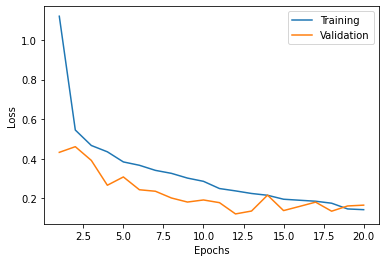

In [25]:
x_plot = list(range(1, epochs + 1))
plot_history(history)

# Energy consumption

In [43]:
energy = keras_spiking.ModelEnergy(model, example_data=np.ones((32, 1, 256, 256, 1)))
energy.summary(
    columns=("name", "energy cpu", "energy gpu", "energy loihi"), dt=2, print_warnings=False
)

2022-05-31 20:48:07.392056: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 520224768 exceeds 10% of free system memory.


Layer (type)                            |J/inf (cpu)|J/inf (gpu)|J/inf (loihi)
----------------------------------------|-----------|-----------|-------------
time_distributed (TimeDistributed)      |       0.04|     0.0014|      0.00025
spiking_activation (SpikingActivation)  |     0.0044|    0.00015|      4.2e-05
time_distributed_1 (TimeDistributed)    |        2.5|      0.088|        0.003
spiking_activation_1 (SpikingActivation)|      0.035|     0.0012|      0.00033
time_distributed_2 (TimeDistributed)    |          0|          0|            0
time_distributed_3 (TimeDistributed)    |        9.6|       0.33|        0.032
spiking_activation_2 (SpikingActivation)|      0.017|    0.00058|      0.00016
time_distributed_4 (TimeDistributed)    |          0|          0|            0
time_distributed_5 (TimeDistributed)    |        2.1|      0.074|      1.1e-10
spiking_activation_3 (SpikingActivation)|    1.1e-06|    3.8e-08|        1e-08
time_distributed_6 (TimeDistributed)    |      7e-05